In [2]:
#originally from @kelu 12/19/2018
import numpy as np
import matplotlib.pyplot as plt 
import math 
import json 
import re
import glob, os

# Let's open a JSON and see what is inside

p_serPU90-2.json
second


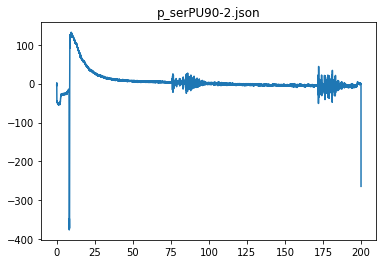

In [3]:
Serie = "wire"
DataSet = {}

for data in glob.glob("*.json"):
    print(data)
    
    
    with open(data) as json_data:
        IDLine = []
        TT1 = []
        TT2 = []
        tmp = [] 
        DataSet[data] = {}
        d = json.load(json_data)
        json_data.close()
        
        A = d["data"][1:]
        
        if (A[0]) > 128:
            print("first")
            for i in range(int(len(A)/2)-1):
                value = 128*(A[2*i+0]&0b0000111) + A[2*i+1] - 512
                IDLine.append((A[2*i+1]&0b11110000)/16) # Identify the # of the line
                TT1.append( (A[2*i+0] & 0b00001000) / 0b1000)
                TT2.append( (A[2*i+0] & 0b00010000) / 0b10000)
                tmp.append( value ) 
        else:
            print("second")
            for i in range(int(len(A)/2)-1):
                value = 128*(A[2*i+1]&0b111) + A[2*i+2] - 512
                IDLine.append((A[2*i+1]&0b11110000)/16)
                TT1.append( (A[2*i+1] & 0b00001000) / 0b1000)
                TT2.append( (A[2*i+1] & 0b00010000) / 0b10000)
                tmp.append( value )
        DataSet[data]["data"] = tmp
        DataSet[data]["IDLine"] = IDLine
        DataSet[data]["TT1"] = TT1
        DataSet[data]["TT2"] = TT2
        DataSet[data]["registers"] = d["registers"]
        DataSet[data]["position"] = d["position"]
        DataSet[data]["f"] = float(64/((1.0+int( d["registers"]["237"] ) )))
        t = [ 1.0*x/DataSet[data]["f"] for x in range(len(tmp))]
        DataSet[data]["t"] = t
        
        plt.plot(t,tmp)
        plt.title(data)
        plt.savefig(data+".jpg")
        plt.show()

### Pulse parameters

Below reads: Pulse is on for 200ns, then waits 300ns, then the pulser damps the pulse during 2300ns.
The acquisition starts 10ns after this, and lasts for 200us (LengthAcq - DeltaAcq).

In [5]:
d["parameters"]

{'DeltaAcq': 2310,
 'LengthAcq': 202310,
 'Poff': 2300,
 'Pon': 200,
 'PulsesDelay': 300}

Acquisition speed is set a 64Msps, let's check it

In [10]:
DataSet[data]["f"]

64.0

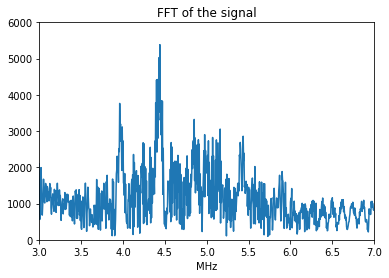

In [24]:
f = [x*DataSet[data]["f"]/len(tmp) for x in range(len(tmp))]
FFT = np.abs(np.fft.fft(tmp))
             
plt.plot(f[1:int(len(tmp)/2)], FFT[1:int(len(tmp)/2)] )
plt.title("FFT of the signal")
plt.xlabel("MHz")
plt.xlim([3,7])
plt.ylim([0,6000])
plt.show()

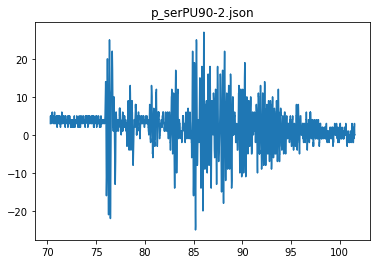

In [25]:
plt.plot(t[4500:6500],tmp[4500:6500])
plt.title(data)
#plt.savefig("nostraw.jpg")
plt.show()

In [26]:
9e-6*1500/2

0.00675

/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


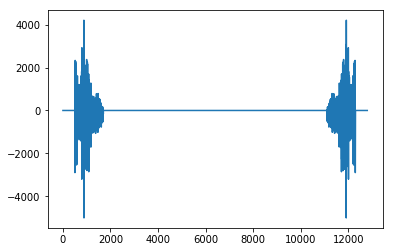

In [42]:
L = len(DataSet[data]["data"])
CleanedFFT = np.fft.fft(tmp)
for k in range(int(L/2)+2):
    if (k < 500) or (k >1700 ):
        CleanedFFT[k] = 0
        CleanedFFT[-k] = 0
plt.plot(CleanedFFT)
plt.show()

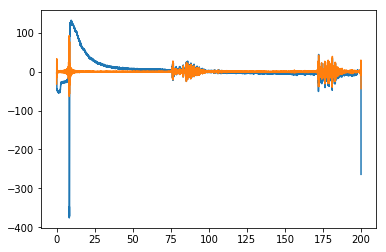

In [49]:
CleanSignal = np.real(np.fft.ifft(CleanedFFT))
plt.plot(t,tmp)
plt.plot(t,CleanSignal)
plt.show()

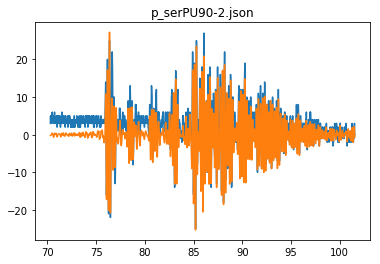

In [46]:
plt.plot(t[4500:6500],tmp[4500:6500])
plt.plot(t[4500:6500],CleanSignal[4500:6500])
plt.title(data)
#plt.savefig("nostraw.jpg")
plt.show()

In [53]:
REG = [int(x) for x in d["registers"].keys() if int(x) < 100]
REG.sort() 
dac = []
for k in REG:
    dac.append(d["registers"][str(k)])
# Building the DAC timeline
tdac = []
for pts in t[0:L]:
    i = int(pts/5.0) # time in us
    try:
        tdac.append(4.0*d["registers"][str(i+16)])
    except:
        tdac.append(-1)

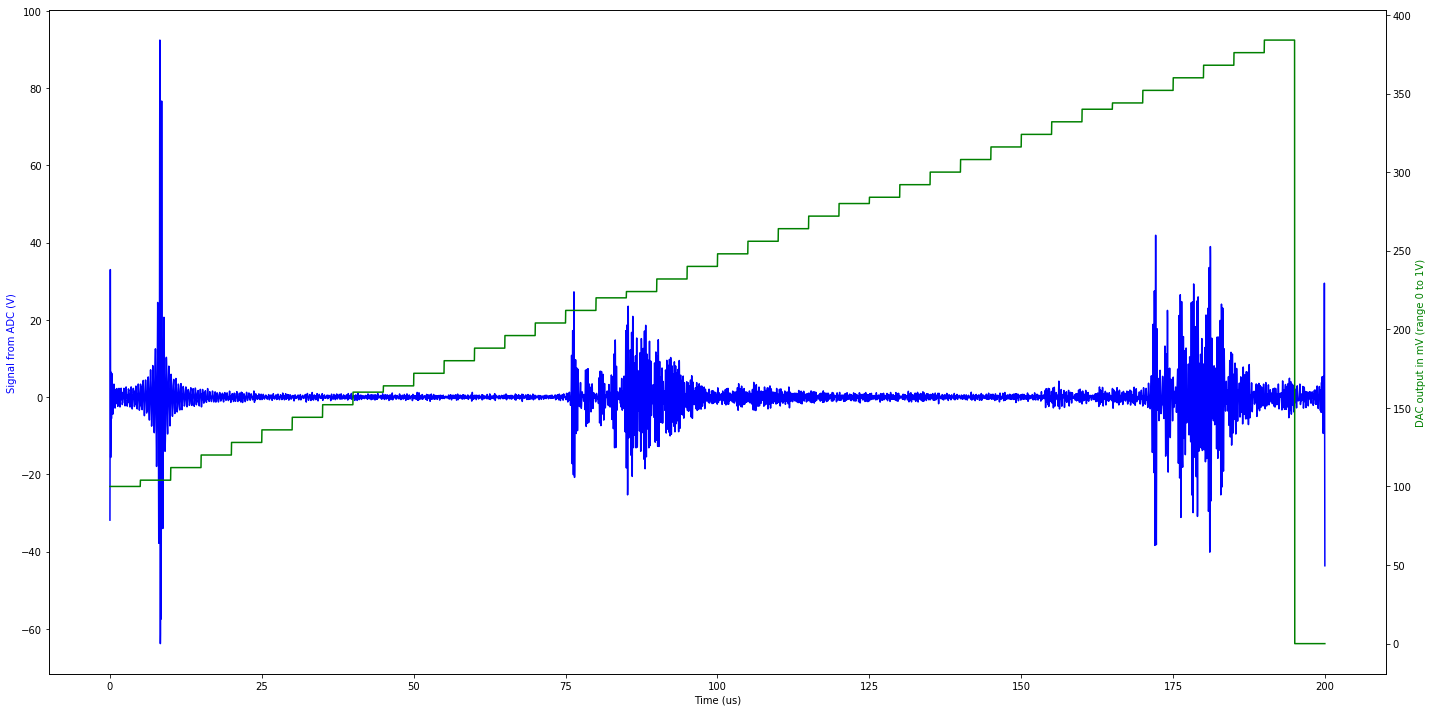

In [55]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx() 
ax2.plot(t, tdac, 'g-')
ax1.plot(t, CleanSignal, 'b-')
ax1.set_xlabel('Time (us)')
ax1.set_ylabel('Signal from ADC (V)', color='b')
ax2.set_ylabel('DAC output in mV (range 0 to 1V)', color='g')
plt.tight_layout()
plt.show() 